# Hyperspectral vs. RGB clustering notebook using RAPIDS
In this notebook, we use the RAPIDs toolkit to segment a hyperspectral image from Pavia with 103 bands (visible and infrared spectra) and compare to clustering using 3 bands (Red, Green, and Blue) all leveraging a GPU. 

## First we load packages

In [1]:
import cudf
import cupy
import glob
import xarray
import scipy.io as sio
import datashader as ds
import numpy as np
from collections import OrderedDict
import datashader.transfer_functions as tf
import datashader.reductions as rd
import pandas as pd
import matplotlib.pyplot as plt
from cupyx.scipy.special import kl_div
import seaborn as sns
from matplotlib.colors import LogNorm
import holoviews as hv
import holoviews.operation.datashader as hd
from matplotlib import cm
from cuml import KMeans, PCA
from cuml.cluster import KMeans
from cuml.decomposition import PCA

## Load Data
In the following cell we load the Pavia dataset and convert the wavelengths to nanometers.

In [2]:
data = sio.loadmat('pavia.mat')
gt = sio.loadmat('pavia_gt.mat')
mask = sio.loadmat('PaviaGrTruthMask.mat')
wvs = sio.loadmat('PaviaWavelengths.mat')
hsi = data['paviaU']
gt = gt['paviaU_gt']
mask = mask['PaviaGrTruthMask']
wvs = wvs['PaviaWavelengths']
wvs = cupy.squeeze(np.round(wvs,3),axis=0)*1000
rgb_bands = [56,28,9]

## Preprocess data
Now that we have loaded our data, we will reshape it and extract the Red, Green, and Blue bands to compare clustering with 3 dimensions of the data vs. 103.

In [3]:
hsi_vec = cupy.reshape(hsi,(hsi.shape[0]*hsi.shape[1],hsi.shape[2]))
mask_vec = cupy.reshape(mask,(mask.shape[0]*mask.shape[1],)).astype(bool)
hsi_vec = hsi_vec/cupy.max(hsi_vec)
hsi_vec[hsi_vec==0]=0.0001
hsi_vec = cupy.array(hsi_vec)
RGB_vec = hsi_vec[:,rgb_bands]
RGB = cupy.reshape(RGB_vec,(hsi.shape[0],hsi.shape[1],3))
time = cupy.linspace(0,1,hsi_vec.shape[1])
cdf = cudf.DataFrame(hsi_vec,columns=wvs)
cdf_RGB = cudf.DataFrame(RGB_vec,columns=wvs[rgb_bands])
time_RGB = cupy.linspace(0,1,RGB_vec.shape[1])
data_df = pd.DataFrame(hsi_vec.get(),columns=wvs)
data_df_RGB = pd.DataFrame(RGB_vec.get(),columns=wvs[rgb_bands])

## Investigate inherent dimensionality
Given that we have such a high dimensionality data (103), it is likely that some of these spectra are redundant. We can use a variety of methods to look into the inherent dimensionality of the dataset. First, we will look at the Jensen-Shannon divergence between each possible pair of bands as a measure of dissimilarity. The *lower* the value, the more *similar* the two spectra's distributions are.

In [4]:
sim_mat = cupy.zeros((hsi_vec.shape[1],hsi_vec.shape[1]))
for i in range(0,sim_mat.shape[0]):
    v1 = hsi_vec[:,i]
    for j in range(0,sim_mat.shape[1]):
        v2 = hsi_vec[:,j]
        sim_mat[i,j] = .5*cupy.sum(kl_div(v1,v2))+.5*cupy.sum(kl_div(v2,v1))+0.001
sim_mat = sim_mat/(hsi_vec.shape[1]*hsi_vec.shape[1])

sim_mat_rgb = cupy.zeros((RGB_vec.shape[1],RGB_vec.shape[1]))
for i in range(0,sim_mat_rgb.shape[0]):
    v1 = RGB_vec[:,i]
    for j in range(0,sim_mat_rgb.shape[1]):
        v2 = RGB_vec[:,j]
        sim_mat_rgb[i,j] = .5*cupy.sum(kl_div(v1,v2))+.5*cupy.sum(kl_div(v2,v1))+0.001
sim_mat_rgb = sim_mat_rgb/(RGB_vec.shape[1]*RGB_vec.shape[1])

## Visualize feature similarity
We can attempt to visualize patterns within the dimensionality of the imagery by plotting the *similarity* or *dissimilarity* between spectra.
The following cell plots the Jensen-Shannon measure between each pair of spectra (similar spectra are yellow and dissimilar are in blue). A plot of the histogram of all the scores is also shown to help in choosing a threshold to reduce the dimensionality of the data.

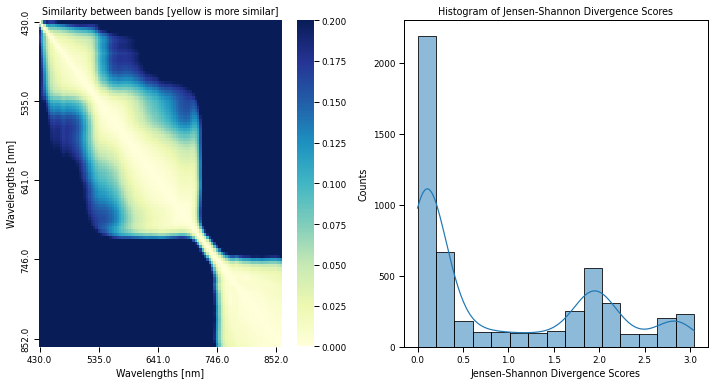

In [5]:
df_RGB = pd.DataFrame(sim_mat_rgb.get(),columns=wvs[rgb_bands],index=wvs[rgb_bands])
df = pd.DataFrame(sim_mat.get(),columns=wvs,index=wvs)
sns.set_context("paper")
fig, (ax0,ax1) = plt.subplots(1,2,figsize=(12,6))
sns.heatmap(ax=ax0, data=df, cmap="YlGnBu", xticklabels=25, yticklabels=25, vmin=0, vmax=0.2)
ax0.set_xlabel("Wavelengths [nm]")
ax0.set_ylabel("Wavelengths [nm]")
ax0.set(title="Similarity between bands [yellow is more similar]");
sns.histplot(ax=ax1,data=np.triu(sim_mat.get()),x=np.unique(sim_mat.get()),kde=True)
ax1.set_xlabel("Jensen-Shannon Divergence Scores")
ax1.set_ylabel("Counts")
ax1.set(title="Histogram of Jensen-Shannon Divergence Scores");

## Visualize raw data (RGB)
Based on the Jensen-Shannon scores, it's clear that the data has some similar spectra within it. If we go to the simplest case, using only the RGB bands, we can view the RGB spectra by running the following cell.

<img src='data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAEAAAABACAYAAACqaXHeAAAABHNCSVQICAgIfAhkiAAAAAlwSFlz
AAAB+wAAAfsBxc2miwAAABl0RVh0U29mdHdhcmUAd3d3Lmlua3NjYXBlLm9yZ5vuPBoAAA6zSURB
VHic7ZtpeFRVmsf/5966taWqUlUJ2UioBBJiIBAwCZtog9IOgjqACsogKtqirT2ttt069nQ/zDzt
tI4+CrJIREFaFgWhBXpUNhHZQoKBkIUASchWla1S+3ar7r1nPkDaCAnZKoQP/D7mnPOe9/xy76n3
nFSAW9ziFoPFNED2LLK5wcyBDObkb8ZkxuaoSYlI6ZcOKq1eWFdedqNzGHQBk9RMEwFAASkk0Xw3
ETacDNi2vtvc7L0ROdw0AjoSotQVkKSvHQz/wRO1lScGModBFbDMaNRN1A4tUBCS3lk7BWhQkgpD
lG4852/+7DWr1R3uHAZVQDsbh6ZPN7CyxUrCzJMRouusj0ipRwD2uKm0Zn5d2dFwzX1TCGhnmdGo
G62Nna+isiUqhkzuKrkQaJlPEv5mFl2fvGg2t/VnzkEV8F5ioioOEWkLG86fvbpthynjdhXYZziQ
x1hC9J2NFyi8vCTt91Fh04KGip0AaG9zuCk2wQCVyoNU3Hjezee9bq92duzzTmxsRJoy+jEZZZYo
GTKJ6SJngdJqAfRzpze0+jHreUtPc7gpBLQnIYK6BYp/uGhw9YK688eu7v95ysgshcg9qSLMo3JC
4jqLKQFBgdKDPoQ+Pltb8dUyQLpeDjeVgI6EgLIQFT5tEl3rn2losHVsexbZ3EyT9wE1uGdkIPcy
BGxn8QUq1QrA5nqW5i2tLqvrrM9NK6AdkVIvL9E9bZL/oyfMVd/jqvc8LylzRBKDJSzIExwhQzuL
QYGQj4rHfFTc8mUdu3E7yoLtbTe9gI4EqVgVkug2i5+uXGo919ixbRog+3fTbQ8qJe4ZOYNfMoTI
OoshUNosgO60AisX15aeI2PSIp5KiFLI9ubb1vV3Qb2ltwLakUCDAkWX7/nHKRmmGIl9VgYsUhJm
2NXjKYADtM1ygne9QQDIXlk49FBstMKx66D1v4+XuQr7vqTe0VcBHQlRWiOCbmmSYe2SqtL6q5rJ
zsTb7lKx3FKOYC4DoqyS/B5bvLPxvD9Qtf6saxYLQGJErmDOdOMr/zo96km1nElr8bmPOBwI9COv
HnFPRIwmkSOv9kcAS4heRsidOkpeWBgZM+UBrTFAXNYL5Vf2ii9c1trNzpYdaoVil3WIc+wdk+gQ
noie3ecCcxt9ITcLAPWt/laGEO/9U6PmzZkenTtsSMQ8uYywJVW+grCstAvCIaAdArAsIWkRDDs/
KzLm2YcjY1Lv0UdW73HabE9n6V66cxSzfEmuJssTpKGVp+0vHq73FwL46eOjpMpbRAnNmJFrGJNu
Ukf9Yrz+3rghiumCKNXXWPhLYcjxGsIpoCMsIRoFITkW8AuyM8jC1+/QLx4bozCEJIq38+1rtpR6
V/yzb8eBlRb3fo5l783N0CWolAzJHaVNzkrTzlEp2bQ2q3TC5gn6wpnoQAmwSiGh2GitnTmVMc5O
UyfKWUKCIsU7+fZDKwqdT6DDpvkzAX4/+AMFjk0tDp5GRXLpQ2MUmhgDp5gxQT8+Y7hyPsMi8uxF
71H0oebujHALECjFKaW9Lm68n18wXp2kVzIcABytD5iXFzg+WVXkegpAsOOYziqo0OkK76GyquC3
ltZAzMhhqlSNmmWTE5T6e3IN05ITFLM4GdN0vtZ3ob8Jh1NAKXFbm5PtLU/eqTSlGjkNAJjdgn/N
aedXa0tdi7+t9G0FIF49rtMSEgAs1kDLkTPO7ebm4IUWeyh1bKomXqlgMG6kJmHcSM0clYLJ8XtR
1GTnbV3F6I5wCGikAb402npp1h1s7LQUZZSMIfALFOuL3UUrfnS8+rez7v9qcold5tilgHbO1fjK
9ubb17u9oshxzMiUBKXWqJNxd+fqb0tLVs4lILFnK71H0Ind7uiPgACVcFJlrb0tV6DzxqqTIhUM
CwDf1/rrVhTa33/3pGPxJYdQ2l2cbgVcQSosdx8uqnDtbGjh9SlDVSMNWhlnilfqZk42Th2ZpLpf
xrHec5e815zrr0dfBZSwzkZfqsv+1FS1KUknUwPARVvItfKUY+cn57yP7qv07UE3p8B2uhUwLk09
e0SCOrK+hbdYHYLjRIl71wWzv9jpEoeOHhGRrJAzyEyNiJuUqX0g2sBN5kGK6y2Blp5M3lsB9Qh4
y2Ja6x6+i0ucmKgwMATwhSjdUu49tKrQ/pvN5d53ml2CGwCmJipmKjgmyuaXzNeL2a0AkQ01Th5j
2DktO3Jyk8f9vcOBQHV94OK+fPumJmvQHxJoWkaKWq9Vs+yUsbq0zGT1I4RgeH2b5wef7+c7bl8F
eKgoHVVZa8ZPEORzR6sT1BzDUAD/d9F78e2Tzv99v8D+fLVTqAKAsbGamKey1Mt9Ann4eH3gTXTz
idWtAJ8PQWOk7NzSeQn/OTHDuEikVF1R4z8BQCy+6D1aWRfY0tTGG2OM8rRoPaeIj5ZHzJxszElN
VM8K8JS5WOfv8mzRnQAKoEhmt8gyPM4lU9SmBK1MCQBnW4KONT86v1hZ1PbwSXPw4JWussVjtH9Y
NCoiL9UoH/6PSu8jFrfY2t36erQHXLIEakMi1SydmzB31h3GGXFDFNPaK8Rme9B79Ixrd0WN+1ij
NRQ/doRmuFLBkHSTOm5GruG+pFjFdAmorG4IXH1Qua6ASniclfFtDYt+oUjKipPrCQB7QBQ2lrgP
fFzm+9XWUtcqJ3/5vDLDpJ79XHZk3u8nGZ42qlj1+ydtbxysCezrydp6ugmipNJ7WBPB5tydY0jP
HaVNzs3QzeE4ZpTbI+ZbnSFPbVOw9vsfnVvqWnirPyCNGD08IlqtYkh2hjZ5dErEQzoNm+6ykyOt
Lt5/PQEuSRRKo22VkydK+vvS1XEKlhCJAnsqvcVvH7f/ZU2R67eXbMEGAMiIV5oWZWiWvz5Fv2xG
sjqNJQRvn3Rs2lji/lNP19VjAQDgD7FHhujZB9OGqYxRkZxixgRDVlqS6uEOFaJUVu0rPFzctrnF
JqijImVp8dEKVWyUXDk92zAuMZ6bFwpBU1HrOw6AdhQgUooChb0+ItMbWJitSo5Ws3IAOGEOtL53
0vHZih9sC4vtofZ7Qu6523V/fmGcds1TY3V36pUsBwAbSlxnVh2xLfAD/IAIMDf7XYIkNmXfpp2l
18rkAJAy9HKFaIr/qULkeQQKy9zf1JgDB2uaeFNGijo5QsUyacNUUTOnGO42xSnv4oOwpDi1zYkc
efUc3I5Gk6PhyTuVKaOGyLUAYPGIoY9Pu/atL/L92+4q9wbflRJ2Trpm/jPjdBtfnqB/dIThcl8A
KG7hbRuKnb8qsQsVvVlTrwQAQMUlf3kwJI24Z4JhPMtcfng5GcH49GsrxJpGvvHIaeem2ma+KSjQ
lIwUdYyCY8j4dE1KzijNnIP2llF2wcXNnsoapw9XxsgYAl6k+KzUXbi2yP3KR2ecf6z3BFsBICdW
nvnIaG3eHybqX7vbpEqUMT+9OL4Qpe8VON7dXuFd39v19FoAABRVePbGGuXTszO0P7tu6lghUonE
llRdrhArLvmKdh9u29jcFiRRkfLUxBiFNiqSU9icoZQHo5mYBI1MBgBH6wMNb+U7Pnw337H4gi1Y
ciWs+uks3Z9fztUvfzxTm9Ne8XXkvQLHNytOOZeiD4e0PgkAIAYCYknKUNUDSXEKzdWNpnil7r4p
xqkjTarZMtk/K8TQ6Qve78qqvXurGwIJqcOUKfUWHsm8KGvxSP68YudXq4pcj39X49uOK2X142O0
Tz5/u/7TVybqH0rSya6ZBwD21/gubbrgWdDgEOx9W
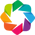

:RGB   [x,y]   (R,G,B,A)

In [6]:
order = [2,1,0]
df_BGR = df_RGB[[df_RGB.columns[i] for i in order]]
hv.extension("bokeh","matplotlib")
hv.output(backend="bokeh")
hd.shade.cmap=cm.Spectral
xticks = [(p/2,df_BGR.columns.values[p]) for p in range(len(df_BGR.columns.values))]
yticks = [(p/10,p*10) for p in range(11)]
cvs = ds.Canvas()
agg = cvs.line(data_df_RGB, x=time_RGB.get(), y=list(df_BGR.columns.values), agg=ds.count(),axis=1)
hd.shade(hv.Image(agg)).opts(height=500,
                             width=1000,
                             xlabel="Wavelength [nm]",
                             ylabel="Reflectance [%]",
                             xticks=xticks,
                             yticks=yticks,
                             title="207,400 Samples From Pavia, Italy with RGB Spectra")

## Visualize raw data [hyperspectral]
Throwing out 100/103 bands might still give us some good results for clustering this imagery, but it isn't clear from the plot above that there are any distinct patterns. Running the following cell will plot the full spectra of each pixel.

In [7]:
hd.shade.cmap=cm.hsv
xticks = [(p/100,df.columns.values[p]) for p in range(len(df.columns.values))]
yticks = [(p/10,p*10) for p in range(11)]
cvs = ds.Canvas()
agg = cvs.line(data_df, x=time.get(), y=list(df.columns.values), agg=ds.count(),axis=1)
hd.shade(hv.Image(agg)).opts(height=500,
                             width=1000,
                             xlabel="Wavelength [nm]",
                             ylabel="Reflectance [%]",
                             xticks=xticks[::10],
                             yticks=yticks,
                             title="207,400 Samples From Pavia, Italy with 103 Spectra")

:RGB   [x,y]   (R,G,B,A)

## Dimensionality reduction with PCA
We can reduce dimensionality with PCA. The following cell keeps the top 10 eigenvectors with highest variance.

In [8]:
pca_float = PCA(n_components=10)
pca_float.fit(cdf)
exp_var_pca = pca_float.explained_variance_ratio_.to_pandas()

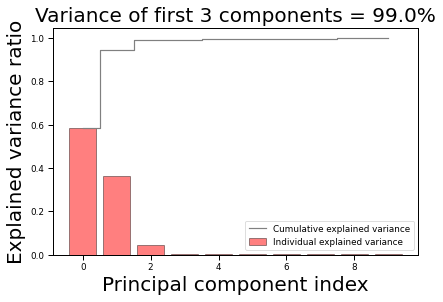

In [9]:
cumulative_sum = np.cumsum(exp_var_pca)
plt.bar(range(0,len(exp_var_pca)), exp_var_pca, alpha=0.5, align='center', label='Individual explained variance', edgecolor='black', color='red')
plt.step(range(0,len(cumulative_sum)), cumulative_sum, where='mid',label='Cumulative explained variance',color='gray')
plt.ylabel('Explained variance ratio',fontsize=20)
plt.xlabel('Principal component index',fontsize=20)
plt.legend(loc='best')
plt.tight_layout()
plt.title(f"Variance of first 3 components = {100*round(cumulative_sum[2],2)}%",fontsize=20)
plt.show()

## Project using top 3 principal components
Since greater than 99% of the variance is contained within the first 3 principal components, we can project the hyperspectral image into 3 dimensions in the following cell.

In [10]:
pca_projected = pca_float.transform(cdf)
pca_projected = pca_projected.iloc[:,:3]

## Unsupervised clustering with K-means
Now that we have visualized the data, we can try to segment it using K-means and varying the input dimensionality. The following cell runs KMeans with 10 clusters for the *hyperspectral*, *RGB*, and *PCA projected* images.

In [11]:
#hyperspectral
kmeans_float = KMeans(n_clusters=10)
kmeans_float.fit(cdf)
C = kmeans_float.cluster_centers_.to_pandas()
L = kmeans_float.labels_.to_pandas()
L_ = L.values
L_ = cupy.reshape(L_,(hsi.shape[0],hsi.shape[1]))

#RGB
kmeans_float_RGB = KMeans(n_clusters=10)
kmeans_float_RGB.fit(cdf_RGB)
C_3 = kmeans_float_RGB.cluster_centers_.to_pandas()
L_RGB = kmeans_float_RGB.labels_.to_pandas()
L_RGB = L_RGB.values
L_RGB = cupy.reshape(L_RGB,(hsi.shape[0],hsi.shape[1]))

#PCA 3 components
kmeans_float_PCA = KMeans(n_clusters=10)
kmeans_float_PCA.fit(pca_projected)
C_3 = kmeans_float_PCA.cluster_centers_.to_pandas()
L_PCA = kmeans_float_PCA.labels_.to_pandas()
L_PCA = L_PCA.values
L_PCA = cupy.reshape(L_PCA,(hsi.shape[0],hsi.shape[1]))

## Plot results
Given our labels, we can compare the labels from the RGB data and the hyperspectral data to determine which is better for segmenting the Pavia image. The following cell plots the Pavia RGB image and the clustering results from the *RGB* image and *hyperspectral* image respectively.

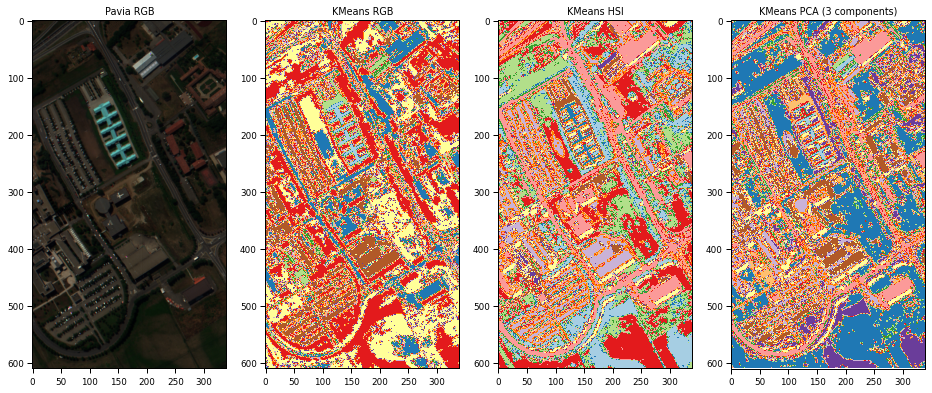

In [12]:
fig, (ax0,ax1,ax2,ax3) = plt.subplots(nrows=1,ncols=4,sharex=True,figsize=(16,8))
ax0.set_title('Pavia RGB')
ax0.imshow(RGB.get())
ax1.set_title('KMeans RGB')
pcm = ax1.imshow(L_RGB,cmap=cm.Paired)
ax2.set_title('KMeans HSI')
pcm = ax2.imshow(L_,cmap=cm.Paired)
ax3.set_title('KMeans PCA (3 components)')
pcm = ax3.imshow(L_PCA,cmap=cm.Paired)

## Visual inspection
We can see from the *RGB* image that classes such as the **road** are **mixed with vegetation**, while the *hyperspectral* image segments out **asphalt** in various regions into a **distinct cluster**. The *PCA* image uses 3 features, but has similar results to the *hyperspectral* image with significantly less dimensionality. Running the following cell will zoom in on each cluster label for further inspection.

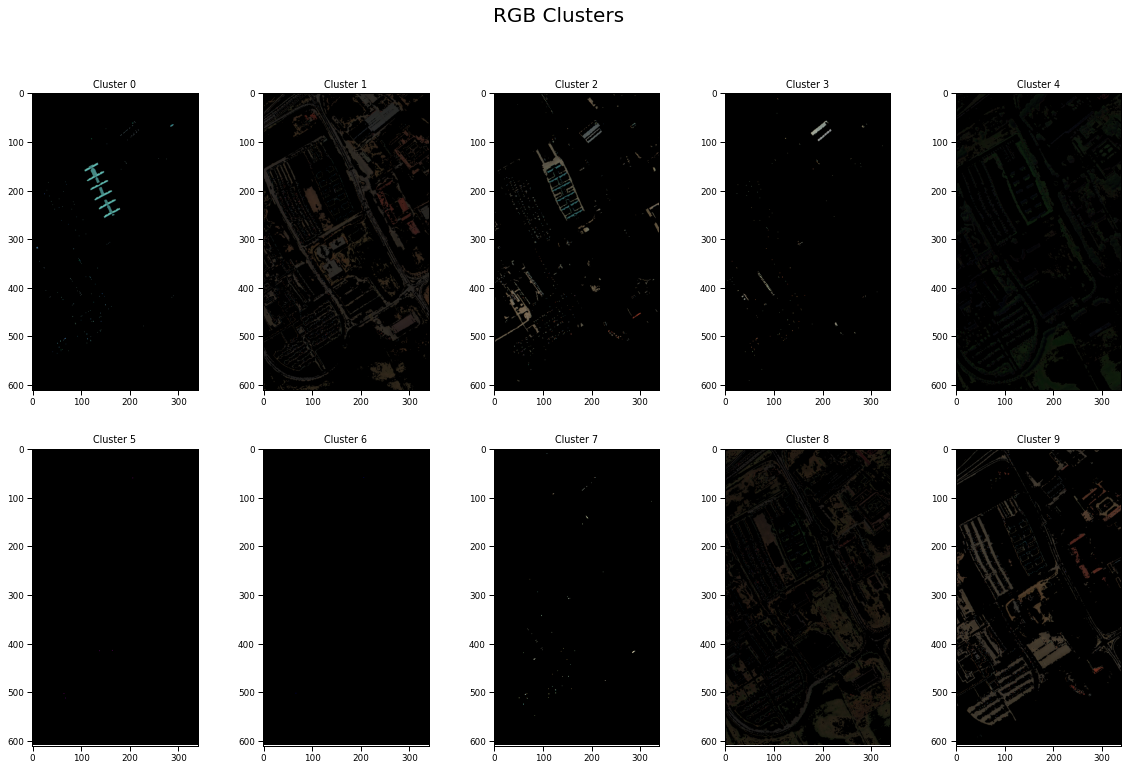

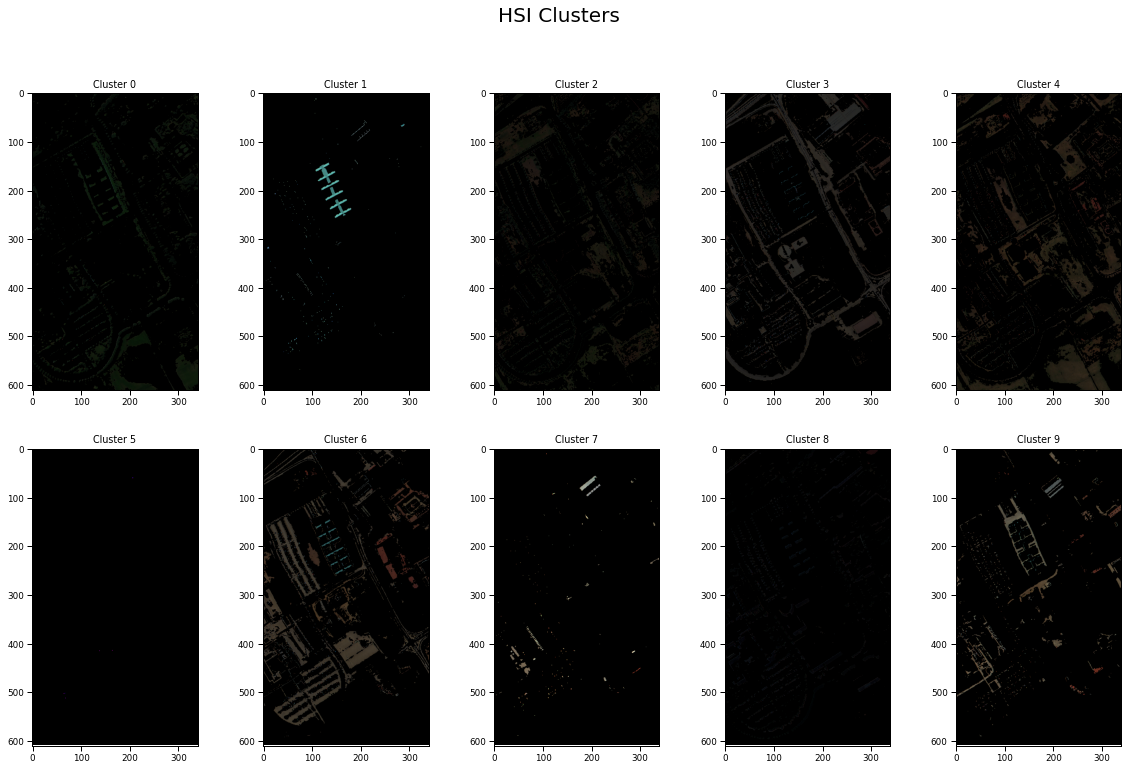

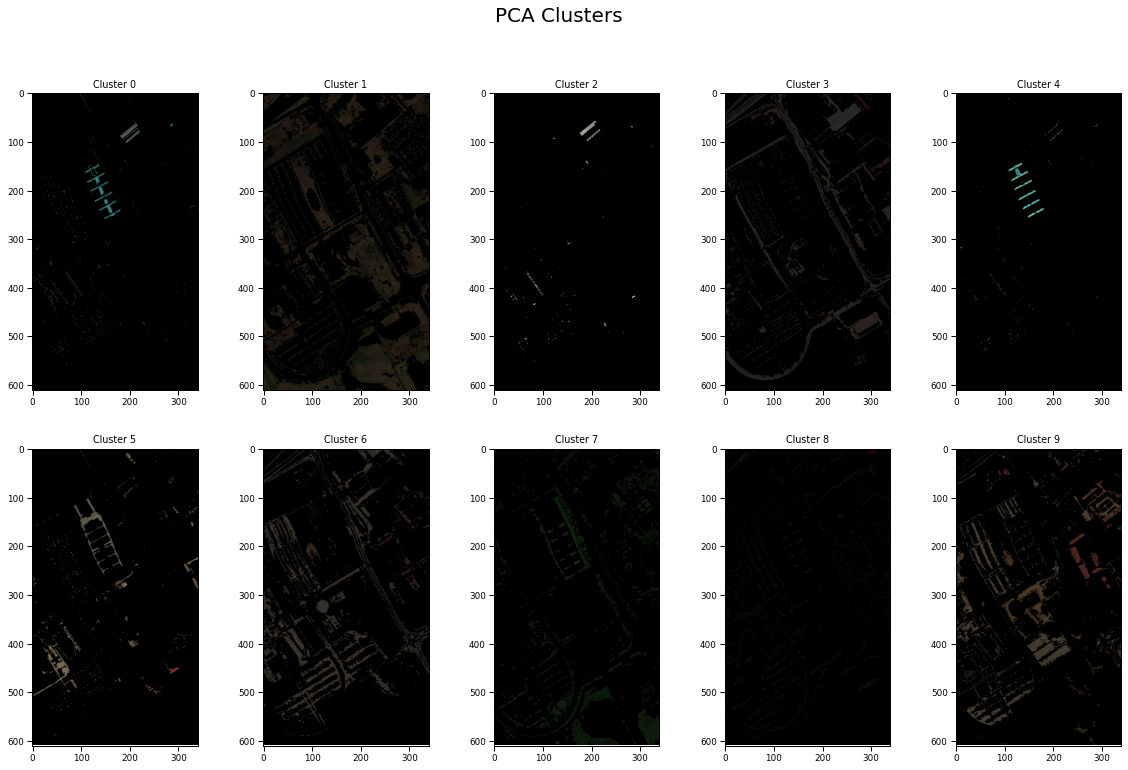

In [13]:
fig,axs = plt.subplots(2,5,figsize=(20,12))
for n in range(10):
    ax = plt.subplot(2,5,n+1)
    rr, cc = np.where(L_RGB==n)
    L_temp = np.zeros((RGB.shape))
    L_temp[rr,cc] = RGB[rr,cc,:].get()
    plt.imshow(L_temp)
    ax.set_title(f"Cluster {n}")
    ax.set_xlabel("")
plt.suptitle("RGB Clusters",fontsize=20);
fig,axs = plt.subplots(2,5,figsize=(20,12))
for n in range(10):
    ax = plt.subplot(2,5,n+1)
    rr, cc = np.where(L_==n)
    L_temp = np.zeros((RGB.shape))
    L_temp[rr,cc] = RGB[rr,cc,:].get()
    plt.imshow(L_temp)
    ax.set_title(f"Cluster {n}")
    ax.set_xlabel("")
plt.suptitle("HSI Clusters",fontsize=20);
fig,axs = plt.subplots(2,5,figsize=(20,12))
for n in range(10):
    ax = plt.subplot(2,5,n+1)
    rr, cc = np.where(L_PCA==n)
    L_temp = np.zeros((RGB.shape))
    L_temp[rr,cc] = RGB[rr,cc,:].get()
    plt.imshow(L_temp)
    ax.set_title(f"Cluster {n}")
    ax.set_xlabel("")
plt.suptitle("PCA Clusters",fontsize=20);